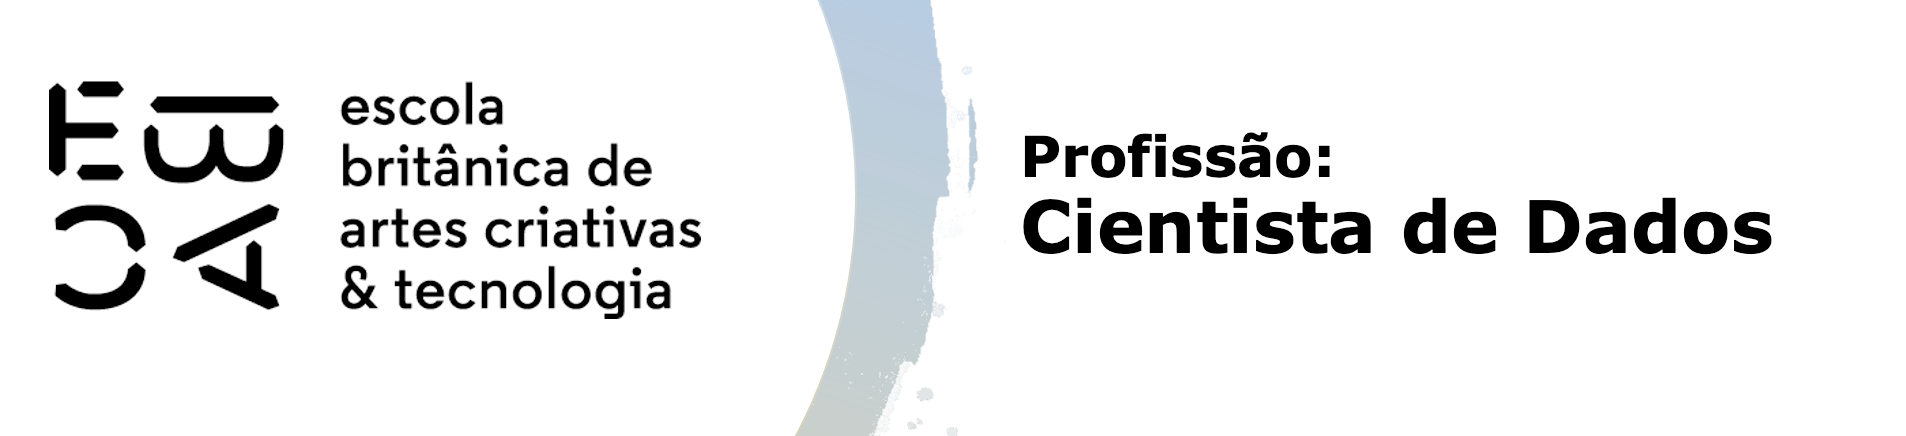

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import t
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import itertools


from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
def importar():
    dados = pd.read_feather('./Dados/credit_scoring.ftr')
    ID = dados.pop("index")
    return dados

In [4]:
df = importar()

In [5]:
df.duplicated().sum()

469661

In [6]:
df.isnull().sum()

data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [7]:
def data_changes(dados):
    dados = dados.copy()
    dados['mes'] = dados['data_ref'].dt.month
    dados = dados.fillna(0)
    dados = dados.drop_duplicates().reset_index(drop=True)
    # Definindo qual é a data voltando 3 meses antes.
    data_max = df['data_ref'].max() - pd.DateOffset(months=3)
    # Aplicando os filtros.
    validation = dados.loc[dados['data_ref'] > data_max]
    dados = dados.loc[dados['data_ref'] <= data_max]
    
    validation = validation.drop(axis=0,columns=['data_ref'])
    dados = dados.drop(axis=0,columns=['data_ref'])
    print(dados.shape, validation.shape)
    
    return dados, validation

In [8]:
df_1, evalu = data_changes(df)

(218354, 14) (61985, 14)


In [9]:
df_1.head()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                N               N           0   Empresário   
1    F                S               S           0  Assalariado   
2    F                N               N           2  Assalariado   
3    F                N               N           0  Assalariado   
4    F                S               N           0  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                Médio     Solteiro            Casa     43       6.873973   
1                Médio       Casado            Casa     35       4.526027   
2                Médio       Casado            Casa     31       0.243836   
3                Médio       Casado            Casa     54      12.772603   
4  Superior incompleto     Solteiro            Casa     31       8.432877   

   qt_pessoas_residencia     renda    mau  mes  
0                    1.0   2515.39  False    1  
1                    2.0   3180.19  False    1  
2                    4.0   1582.29  False    1  
3                    2.0  13721.17  False    1  
4                    1.0   2891.08  False    1

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [10]:
def d_bas(dados):
    dados = dados.copy()
    analise = dados.groupby('mes')[['mau']].count()
    return analise

print("\n\n\nQuantidade de elementos por linha")
d_bas(df_1)




Quantidade de elementos por linha


mau
mes       
1    20066
2    19428
3    18714
4    17993
5    17398
6    17091
7    16998
8    17100
9    17417
10   17948
11   18793
12   19408

In [11]:
print('\n\nAnálise Descritiva Unitária dos valores categóricos')
df_1.select_dtypes(exclude=np.number).describe().T



Análise Descritiva Unitária dos valores categóricos


count unique          top    freq
sexo              218354      2            F  147334
posse_de_veiculo  218354      2            N  133460
posse_de_imovel   218354      2            S  145602
tipo_renda        218354      5  Assalariado  112685
educacao          218354      5        Médio  148059
estado_civil      218354      5       Casado  152898
tipo_residencia   218354      6         Casa  196047
mau               218354      2        False  187670

In [12]:
print('\n\nAnálise Descritiva Unitária dos valores numéricos')
quant = df_1.select_dtypes(include=np.number).describe().T
quant['Unique'] = df_1[quant.index].nunique().values
display(quant)



Análise Descritiva Unitária dos valores numéricos


count          mean           std     min  \
qtd_filhos             218354.0      0.435366      0.741886    0.00   
idade                  218354.0     43.695659     11.281775   22.00   
tempo_emprego          218354.0      6.125176      6.510449    0.00   
qt_pessoas_residencia  218354.0      2.213278      0.906484    1.00   
renda                  218354.0  24523.591643  81265.341702  161.86   
mes                    218354.0      6.449206      3.532069    1.00   

                               25%          50%           75%           max  \
qtd_filhos                0.000000     0.000000      1.000000  1.400000e+01   
idade                    34.000000    43.000000     53.000000  6.800000e+01   
tempo_emprego             1.115068     4.454795      8.673973  4.290685e+01   
qt_pessoas_residencia     2.000000     2.000000      3.000000  1.500000e+01   
renda                  4090.742500  8775.230000  19506.945000  4.083986e+06   
mes                       3.000000     6.000000     10.000000  1.200000e+01   

                       Unique  
qtd_filhos                  8  
idade                      47  
tempo_emprego            3005  
qt_pessoas_residencia       9  
renda                  112472  
mes                        12

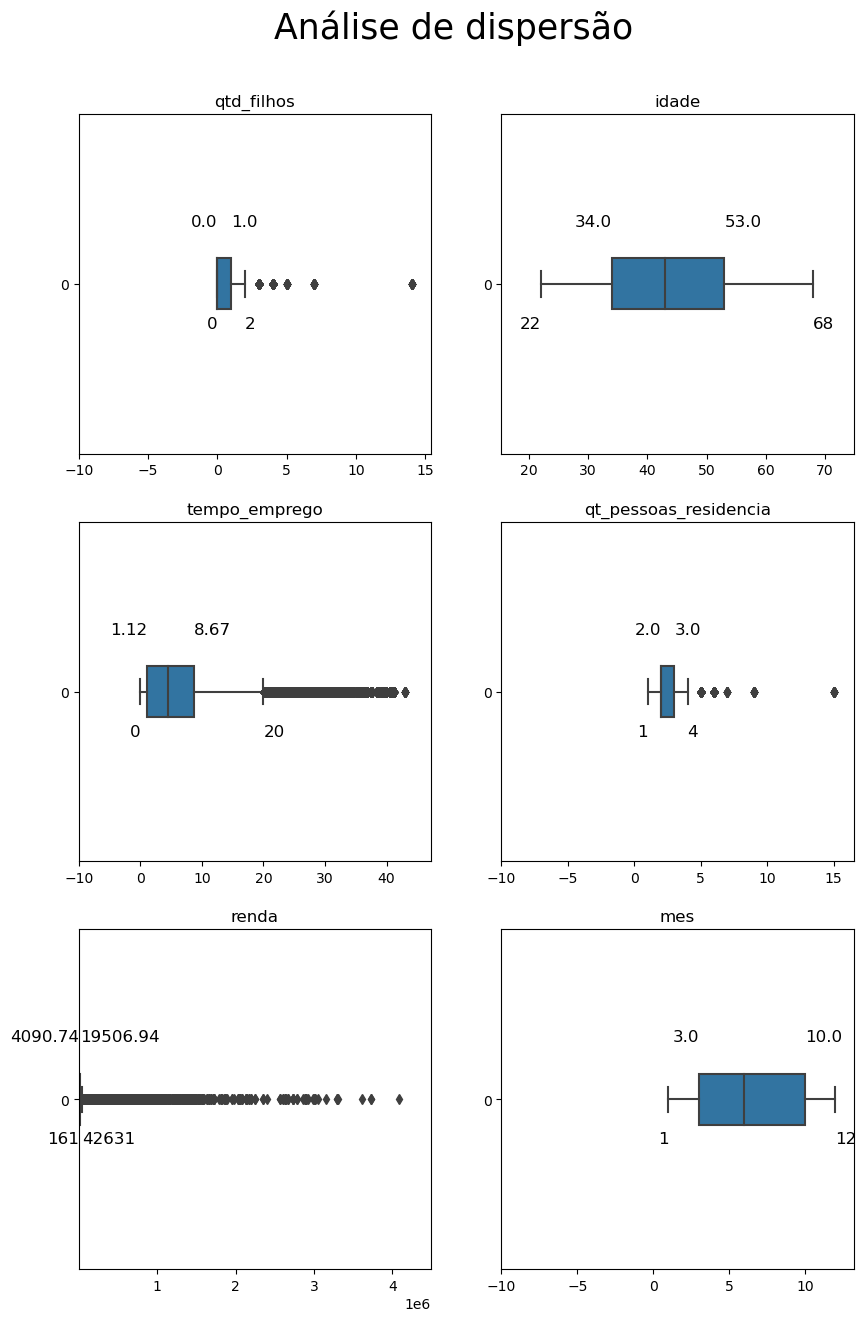

In [13]:
def box():
    numbers = df_1.select_dtypes(include=np.number)
    
    figure = plt.figure(figsize=(10,15))
    plt.suptitle("Análise de dispersão", fontsize=25, y=0.95)
    size = (3,2)
    c = 0
    for row in range(3):
        for col_ in range(2):
            ax = plt.subplot2grid(size, (row, col_))
            col = numbers.columns[c]
            plt.title(col)
            
            fig = sns.boxplot(df_1[col], orient='h', ax=ax, width=.15)
            if df_1[col].min() <= 1:                
                ax.set_xlim([-10, df_1[col].max()*1.1])
            else:
                ax.set_xlim([df_1[col].min()*.7, df_1[col].max()*1.1])
                
                
            quantiles = df_1[col].quantile([0.25, 0.75]).values.tolist() # Separação dos quantiles.
            LI = quantiles[0] - ((quantiles[1] - quantiles[0])*1.5) # Definir limite inferior
            LS = quantiles[1] + ((quantiles[1] - quantiles[0])*1.5) # Definir limte superior
            if LI < df_1[col].min(): # Loop que vai reposicionar em caso de valores abaixo/acima do cálculado.
                LI = df_1[col].min()
            if LS > df_1[col].max():
                LS = df_1[col].max()

            posse = ['right', 'left'] # Reajustar a posição no boxplot.
            for ix,poss in zip([int(LI),int(LS)],posse): # Plotar no gráfico.
                fig.annotate(round(ix,2), xy=(ix, 0.13), fontsize=12, color='black',horizontalalignment=poss)
            for ix,poss in zip(quantiles,posse):
                fig.annotate(round(ix,2), xy=(ix, -0.17), fontsize=12, color='black',horizontalalignment=poss)
            
            c += 1
    
        
box()

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
As variáveis tempo de emprego e renda são as que apresentam outliers
</div>


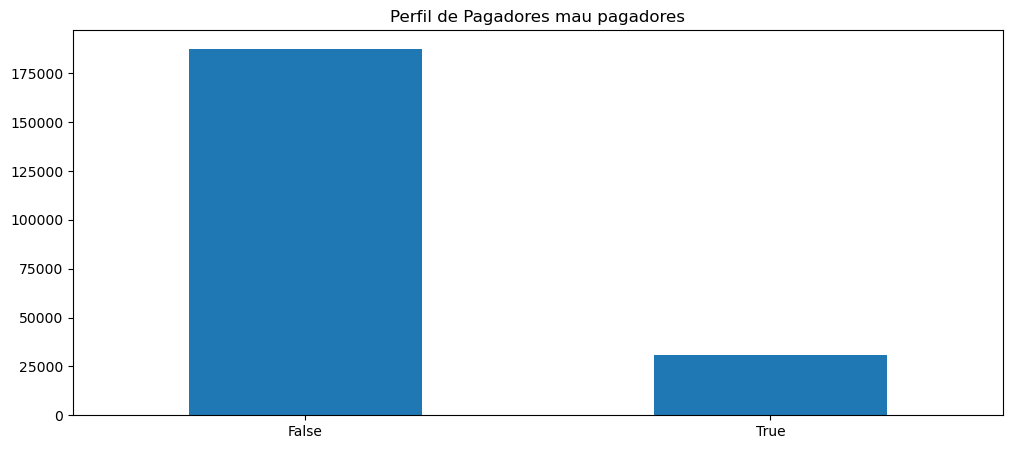

In [14]:
plt.figure(figsize=(12,5))
df_1['mau'].value_counts().plot(kind='bar')
plt.title('Perfil de Pagadores mau pagadores')
plt.xlabel('')
plt.xticks(rotation=0);

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
O gráfico acima demonstra que há um desbalanceamento entre a variável resposta, sendo necessário um tratamento.
Diversas abordagens podem ser feitas, sendo mais comuns o uso de under ou over sampling.
Aqui será operado um método ensemble de árvore de decisão, deixando de lado a necessidade de um balanceamento dos dados, visto que o algorítmo se adpta muito bem ao desbalanceamento.
 </div>

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [15]:
class bivariada:
    def __init__(self, variavel=None, resposta=None):
        try:
            self.iv = self.IV(variavel, resposta)
        except:
            self.iv = None
            
            
            
    def IV(self,variavel, resposta):
        tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

        rótulo_evento = tab.columns[0]
        rótulo_nao_evento = tab.columns[1]

        tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
        tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

        tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
        tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
        tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
        return tab['iv_parcial'].sum()
    
    
    
    def biv_discreta(self, var, dt):
        dados = dt.copy()
        if dados[var].nunique() > 12:
            dados.loc[:,var] = pd.qcut(dados[var], 5).astype(str)
        dados['bom'] = 1-dados.mau
        g = dados.groupby(var)

        biv = pd.DataFrame({'qt_bom': g['bom'].sum(), # Total of reliable payers
                            'qt_mau': g['mau'].sum(), # Total of unreliable payers
                            'mau':g['mau'].mean(), 
                            var: g['mau'].mean().index, 
                            'cont':g[var].count()})

        biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
        # Using the scipy library to estimate the confidence interval.
        biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep 
        biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep


        biv['logit'] = np.log(biv.mau/(1-biv.mau))
        biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
        biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

        tx_mau_geral = df.mau.mean()
        woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

        biv['woe'] = biv.logit - woe_geral
        biv['woe_sup'] = biv.logit_sup - woe_geral
        biv['woe_inf'] = biv.logit_inf - woe_geral

        return biv
    
    def grafico(self,colunas, dados):
        
        dt = dados.copy()
        tamanho = (7, 2)
        figura = plt.figure(figsize=(10,30))
        plt.suptitle('Gráfico de Correlação Bivariada (WOE)',y=.94, fontsize=30)
        outer = gridspec.GridSpec(7, 2, height_ratios=[1, 1, 1, 1, 1, 1, 1], hspace=0.4, wspace=0.4)
        c = 0


        for row in range(tamanho[0]):
            for col in range(tamanho[1]):
                column = colunas[c]
                biv = bivariada().biv_discreta(column, dt)

                inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col], hspace=0.1)

                if c == 12:
                    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col:], hspace=0.1)
                    ax = plt.Subplot(figura, inner[0, 0:])
                    figura.add_subplot(ax)
                    plt.title(column)
                    ax.plot(biv[column], biv.woe, ':bo', label='woe')
                    ax.plot(biv[column], biv.woe_sup, 'o:r', label='limite superior')
                    ax.plot(biv[column], biv.woe_inf, 'o:r', label='limite inferior')
                    handles, labels = ax.get_legend_handles_labels()
                    figura.legend(handles, labels, bbox_to_anchor=(0.5, 0.91), loc='upper center', ncol=3)

                    ax.spines['bottom'].set_visible(False)
                    ax.set_xticks([])
                    ax.set_xlabel('')
                    ax.set_ylabel("Weight of Evidence", fontsize=8)
                    
                    ax = plt.Subplot(figura,  inner[1, 0:])
                    figura.add_subplot(ax)
                    ax.spines['top'].set_visible(False) 
                    ax = biv.cont.plot.bar()
                    plt.xticks(rotation=360)
                    ax.set_xlabel('')
                    ax.set_ylabel("Frequency", fontsize=8)
                    break

                ax = plt.Subplot(figura, inner[0])
                figura.add_subplot(ax)
                plt.title(column)
                ax.plot(biv[column], biv.woe, ':bo', label='woe')
                ax.plot(biv[column], biv.woe_sup, 'o:r', label='limite superior')
                ax.plot(biv[column], biv.woe_inf, 'o:r', label='limite inferior')
                num_cat = biv.shape[0]
                ax.set_xlim([-.3, num_cat-.7])
                ax.set_ylabel("Weight of Evidence", fontsize=8)
                

                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                ax.set_xlabel('')

                ax = plt.Subplot(figura, inner[1])
                figura.add_subplot(ax)
                ax.spines['top'].set_visible(False)
                ax = biv.cont.plot.bar()
                plt.xticks(rotation=30, fontsize=7)
                ax.set_xlabel('')
                ax.set_ylabel("Frequency", fontsize=8)

                c += 1
                
        
        return plt.show()
        
            

In [16]:
independente = df_1.columns.tolist()
independente.remove('mau')
tabela = []
for col in independente:
    if df_1[col].nunique()>12:
        iv = bivariada(pd.qcut(df_1[col], 5, duplicates='drop'), df_1['mau']).iv
        tabela.append([col, iv])
    else:
        iv = bivariada(df_1[col], df_1['mau']).iv
        tabela.append([col, iv])
        
tabela = pd.DataFrame(tabela, columns=['variavel','iv']).set_index('variavel')
print("\n\nValor do IV para cada variável independente")
display(tabela)



Valor do IV para cada variável independente


iv
variavel                           
sexo                   1.223322e-03
posse_de_veiculo       6.867877e-07
posse_de_imovel        6.397152e-03
qtd_filhos             1.348652e-03
tipo_renda             8.656056e-03
educacao               3.057546e-03
estado_civil           8.698986e-04
tipo_residencia        2.173024e-03
idade                  1.261383e-02
tempo_emprego          2.016363e-01
qt_pessoas_residencia           inf
renda                  7.202880e-01
mes                    1.927290e-01

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
O infinito do iv pode indicar que há presença de categorias raras, significando que algum tipo de tratamento pode ser realizado sobre esses dados.
</div>




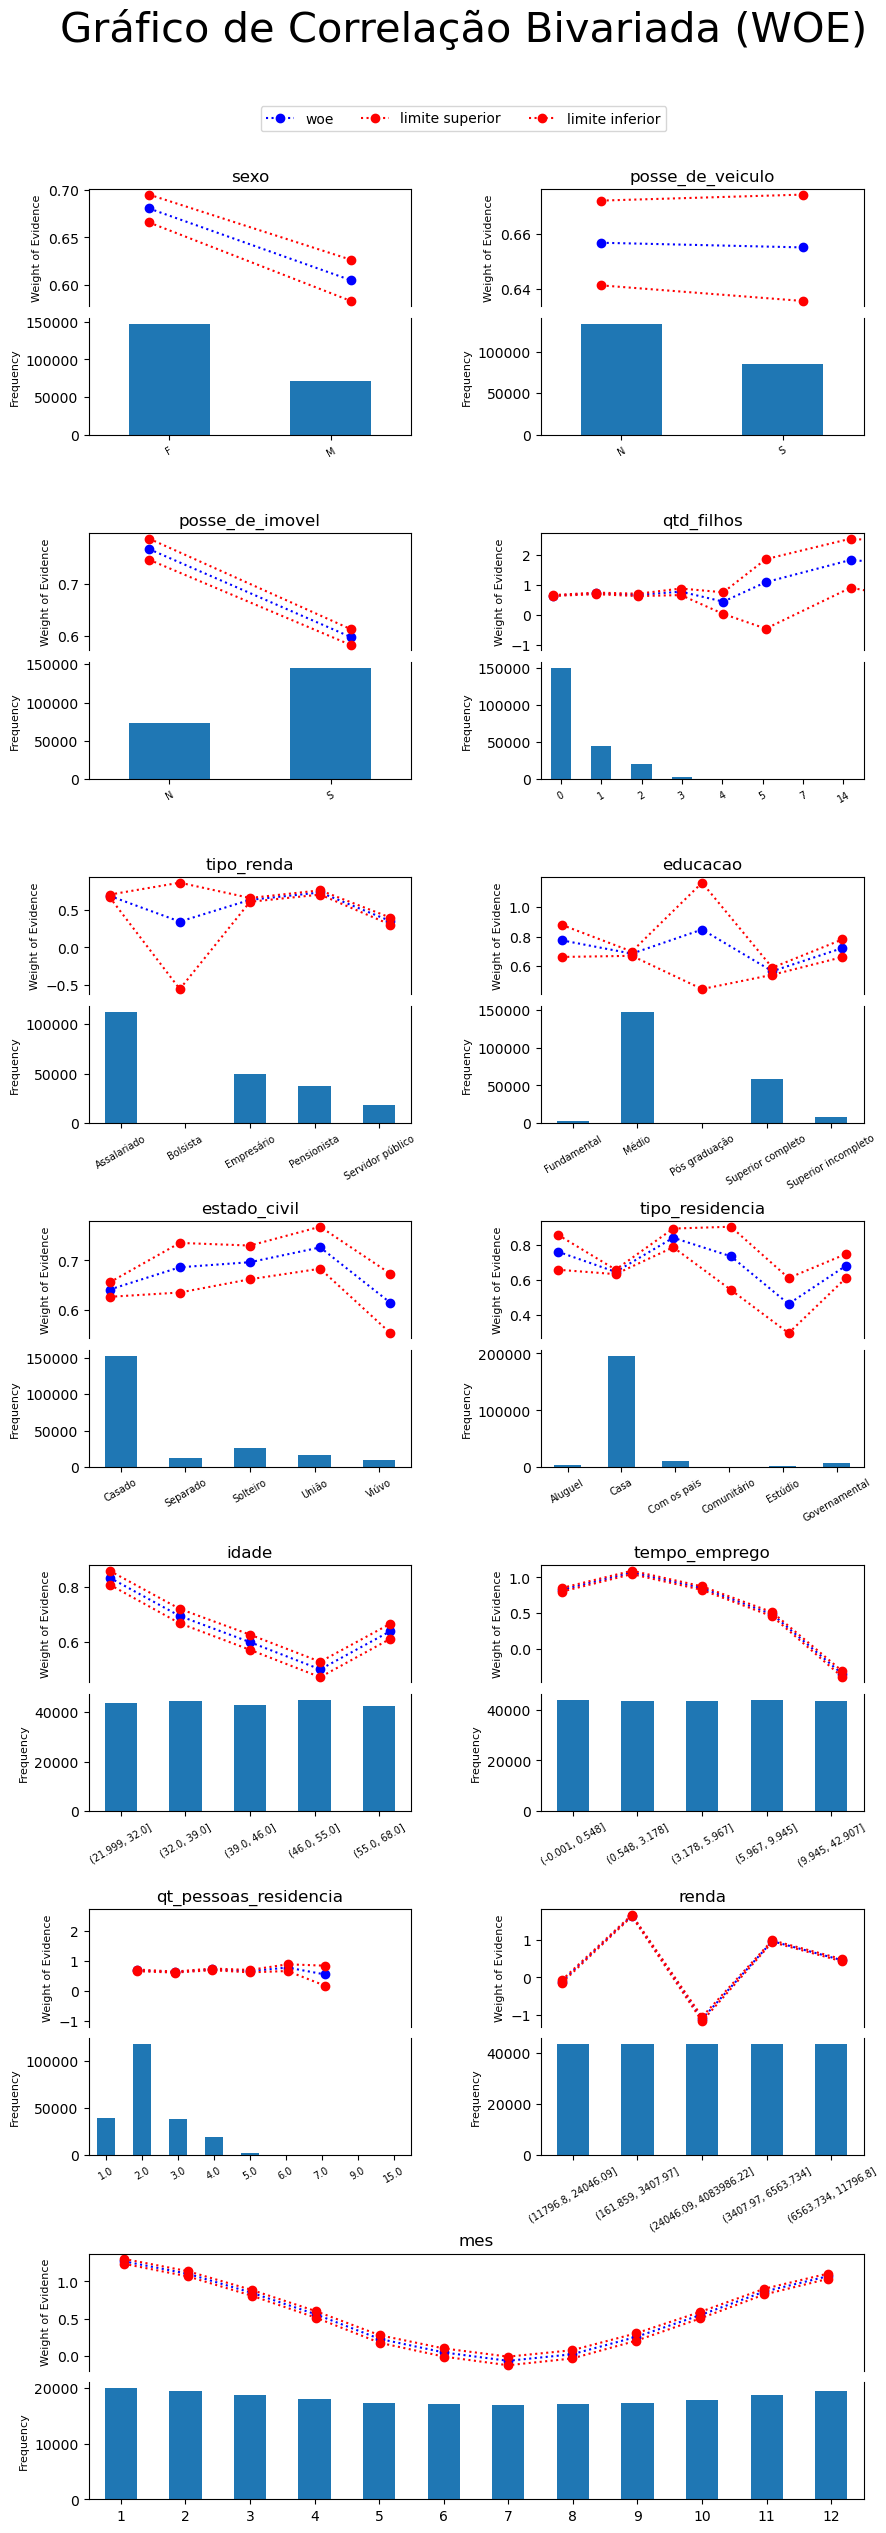

In [17]:
bivariada().grafico(independente, df_1)

In [70]:
df_1.loc[df_1['tipo_renda'] == 'Bolsista', 'tipo_renda'] = 'Pensionista'

1592      Bolsista
2226      Bolsista
5481      Bolsista
6793      Bolsista
7686      Bolsista
            ...   
207816    Bolsista
208943    Bolsista
213561    Bolsista
216912    Bolsista
218108    Bolsista
Name: tipo_renda, Length: 103, dtype: object

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">

#### Explicação Sobre o Gráfico Acima
Intervalo de Confiança Amplo (Largo): Indica que há uma maior incerteza em torno do valor estimado de WOE para essa categoria. Pode ser resultado de uma amostra pequena, alta variabilidade nos dados ou outros fatores que contribuem para a incerteza na estimativa.

Intervalo de Confiança Curto (Estreito): Indica que a estimativa de WOE é mais precisa e há menor incerteza associada a ela. Pode ocorrer quando você tem uma amostra grande e/ou baixa variabilidade nos dados.

Weight of Evidence (WOE) - é uma métrica frequentemente utilizada em modelagem de crédito e análise de risco para avaliar a força de relação entre uma variável independente categórica e a variável dependente binária


WOE Positivo: Se o WOE é positivo, isso indica uma relação positiva com a variável dependente. Isso sugere que a categoria tem maior probabilidade de estar associada ao evento de interesse (por exemplo, inadimplência em um empréstimo).
WOE Negativo: Se o WOE é negativo, isso indica uma relação negativa com a variável dependente. Nesse caso, a categoria tem menor probabilidade de estar associada ao evento de interesse.
WOE Próximo a Zero: Um WOE próximo a zero sugere que a categoria tem uma probabilidade de evento semelhante à média geral. Pode ser interpretado como uma categoria "neutra" em termos de sua influência na variável dependente.
WOE Infinito ou Indefinido: Se uma categoria tem zero eventos em uma das classes (por exemplo, nenhuma inadimplência), o WOE será indefinido ou infinito.

#### Analisando dados.

Relevâncias de destaque identificadas nos dados: A variável 'quantidade de pessoas por residência' destaca uma questão relacionada à presença de valores infinitos, atribuídos a uma categoria extraordinariamente rara. Ainda que esse fenômeno seja específico dessa categoria em particular, a existência de classes igualmente incomuns em outras variáveis sugere a necessidade de uma abordagem proativa. Recomenda-se a consolidação dessas classes minoritárias em categorias mais abrangentes, visando otimizar a eficiência do algoritmo durante o processamento e a geração de respostas. Outra validação dessa necessidade de tratamento é evidenciada ao analisar o amplo intervalo entre o intervalo de confiança e a frequência das classes, indicando que quanto menor a frequência, maior o intervalo de confiança, resultando em uma maior incerteza sobre o comportamento esperado da classe.
</div>

In [18]:
def posicao(a, b, tamanho):
  """ Funçõa para determinar a posição de cada imagem """

  if b < tamanho[1] -1 :
    b +=1
    return a, b
  else:
    a += 1
    b = 0
    return a, b
    
def imagem_0(df_, alvo, tamanho):
# Configuração Inicial

    tamanho = tamanho
    figura = plt.figure(figsize=(15,20))
    figura.suptitle("Correlação Dados Numéricos", fontsize=30)
    a, b = 0, 0

    for ii in df_.drop(alvo,axis=1):
                            ## Pos
        pos = (a,b)
        ax1 = plt.subplot2grid(tamanho, pos)
        a, b = posicao(a,b,tamanho)
                                ## Plot
        box = sns.boxplot(
            orient='h',
            x = df_[ii],
            y = df_[alvo],
            ax= ax1,
            width = 0.2,
            boxprops= {"facecolor": 'azure', "edgecolor": "grey", "linewidth": 0.5}, # Cor do box e cor das bordas do box
            whiskerprops={"color": "grey", "linewidth": 0.5}, # Cor das linhas acima e abaixo do q1 e 13
            capprops={"color": "grey", "linewidth": 0.5}, # Cor da barra limite 
            medianprops={"color": "grey", "linewidth": 0.5},
            flierprops = dict(marker='+',markersize=4, markeredgecolor='red')
        )




        box.set_title(f'Gráfico : {ii}',horizontalalignment='left', x=0,fontsize=16,color='grey')

                                ## Conf
        for con0, elemento in enumerate(df[alvo].unique()): # Criar loop para mostrar no gráfico a posição de cada quantile.
            df_temporario = df_.loc[df_[alvo] == elemento] # Filtrando os dados somente contendo a classe estudada.
            nome = ii # Alvo
            quantiles = df_temporario[ii].quantile([0.25, 0.75]).values.tolist() # Separação dos quantiles.
            LI = quantiles[0] - ((quantiles[1] - quantiles[0])*1.5) # Limite Inferior
            LS = quantiles[1] + ((quantiles[1] - quantiles[0])*1.5) # Limite Superior
            # Ajustes de posição do LS e LI
            if LI < df_temporario[nome].min():
                LI = df_temporario[nome].min()
            elif LI >= df_temporario[nome].min():
                LI = df_temporario.loc[df_temporario[nome] >= LI, nome].min() 
            if LS > df_temporario[nome].max():
                LS = df_temporario[nome].max()
            elif LS <= df_temporario[nome].max():
                LS = df_temporario.loc[df_temporario[nome] <= LS, nome].max() 

            for con, ix in enumerate([LI,LS]): # Plotar no gráfico.
                if con % 2 == 0: # Se par o plot vai a direita, se não a esquerda.
                    h = 'right'
                else:
                    h = 'left'
            box.annotate(round(ix,2), xy=(ix, con0+0.2), fontsize=12, color='rosybrown', horizontalalignment=h)
            for con, ix in enumerate(quantiles):
                mover = 0.01 # Ajuste para deslocar o texto.
            if con % 2 == 0:
                h = 'right'
            else:
                h = 'left'
            box.annotate(round(ix,2), xy=(ix, con0-0.2), fontsize=12, color='dimgrey', horizontalalignment=h, verticalalignment='bottom')
            box.spines['left'].set_visible(False)
            box.spines['right'].set_visible(False)
            box.spines['top'].set_visible(False)
    return figura.show()

def contagem(a, b,tamanho):
  """
  Função criada para ajustar ao tamanho da posição da axis, onde seria pos(a,b)
  se b for menor que o tamanho desejado -1 ele avança de linha.
  """
  if b < tamanho[1]-1:
    b+=1
    return a,b
  else:
    b=0
    a+=1
    return a,b

def corre_cat(dfe, alvo, tamanho):

    df_ = dfe.copy()
    colunas = df_.columns.tolist()
    colunas.remove(alvo)
    figura = plt.figure(figsize=(15,30))
    figura.suptitle('Correlações Dados Categóricos', fontsize=30, x=0.13, color='grey', horizontalalignment='left')
    tamanho = tamanho
    plt.subplots_adjust(top=0.95,
                      wspace = 0.5,
                      hspace = 0.5)
    a1 = 0
    b1 = 0 
    for column in colunas:
    # try:
        pos = (a1,b1) # Pos
        ax = plt.subplot2grid(tamanho, pos) # Axis
        color = '#78C' # Cor do palette

    # Para destacar Alvo
        if pos == (1,2):
          # color = 'seagreen'
          ax = plt.subplot2grid(tamanho, pos, colspan=2)

# ======= Plot 

        barra = sns.countplot(orient='h',
                              data = df_,
                    y = column,
                    hue = alvo,
                    palette = sns.light_palette(color) ,
                    dodge=False,
                    ax=ax,
                    order = df_[column].value_counts().index) 


        # Mostrar porcengatem de cada categoria.
        bd0 = []
        for un in df_[column].value_counts().index:
            bd = []
            total = df_.loc[(df_[column] == un), column].shape[0] 
            for al in df_[alvo].unique():
                atual = df_.loc[(df_[alvo] == al) & (df_[column] == un), column].value_counts().values
                if atual.size <= 0:
                    bd.append([0])
                else:
                    bd.append(round(((atual/total)*100)[0],2))
            bd0.append(bd)
        for con, un in enumerate(bd0):
            if un[0] == 0:
                continue
            elif len(un) == 1:
                barra.annotate(
                        f'100% de  Falso \n 0% de Verdadeiro',
                        xy = (df_[column].value_counts()[0]/3, con),
                        horizontalalignment='center',verticalalignment='center'
                )
            else:

                barra.annotate(
                        f'{un[0]}% de  Bom \n{un[1]}% de Mau',
                        xy = (df_[column].value_counts()[0]/3, con),
                        horizontalalignment='center',verticalalignment='center'
                )


        # Ajustes de configuração de axis.
        barra.set_title(f"Contagem das categorias: {column}", horizontalalignment='left', color='grey', x=0)
          # Desativar
        barra.spines['top'].set_visible(False)
        barra.spines['right'].set_visible(False)
        barra.spines['left'].set_visible(False)
          # Cor
        barra.spines['bottom'].set_color('darkgrey')
        barra.tick_params(axis='y', colors='black')
        barra.tick_params(axis='x', colors='darkgrey')

        # Atualizar Pos da axis
        a1,b1 = contagem(a1,b1,tamanho)
        # except:
        #   pass
    return figura.show()

In [19]:
# Selecionando somente os numéricos
a_n = df_1.select_dtypes(include=np.number)
a_n['mau'] = df_1.mau


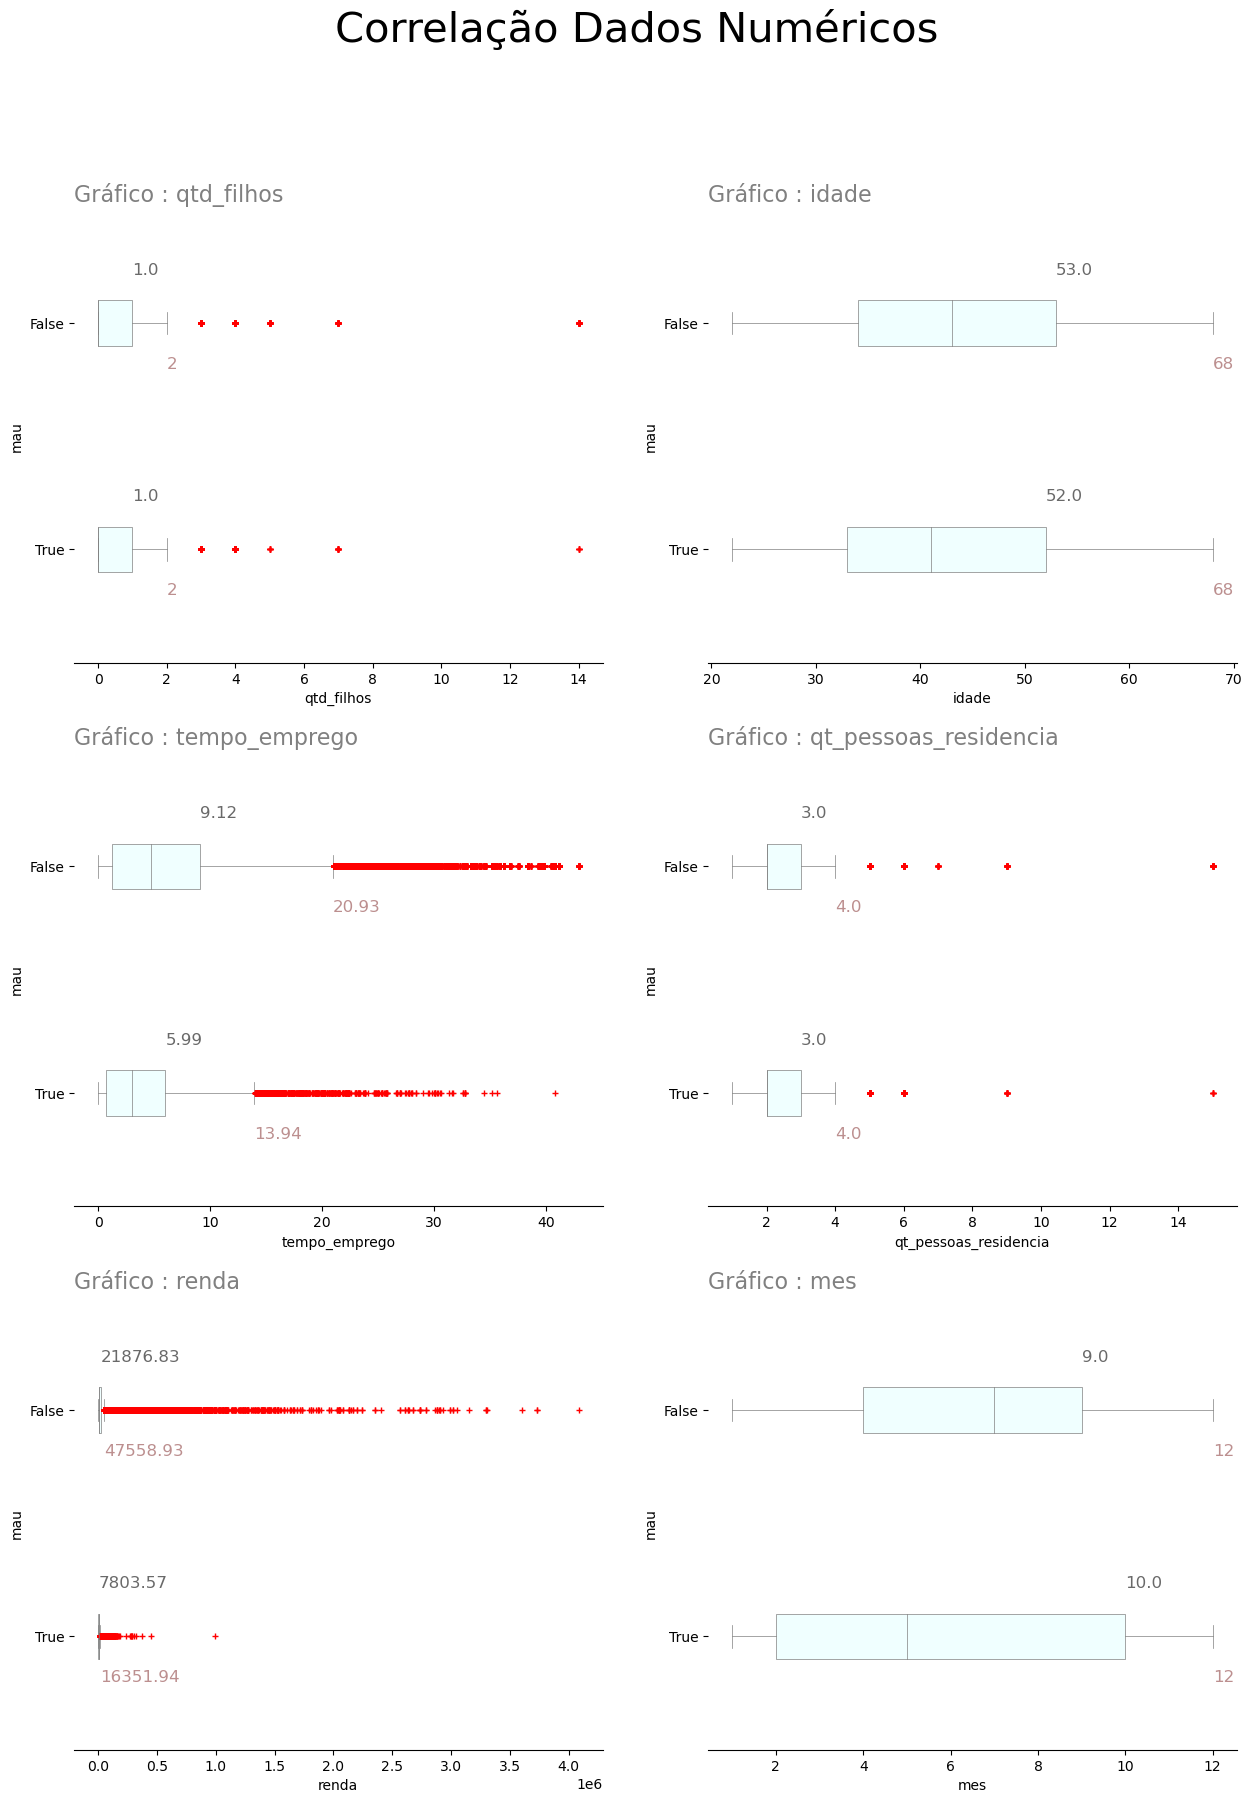

In [20]:
imagem_0(a_n, 'mau', (3,2))

In [21]:
# Criação dados categóricos
a_c = df_1.select_dtypes(exclude=np.number)

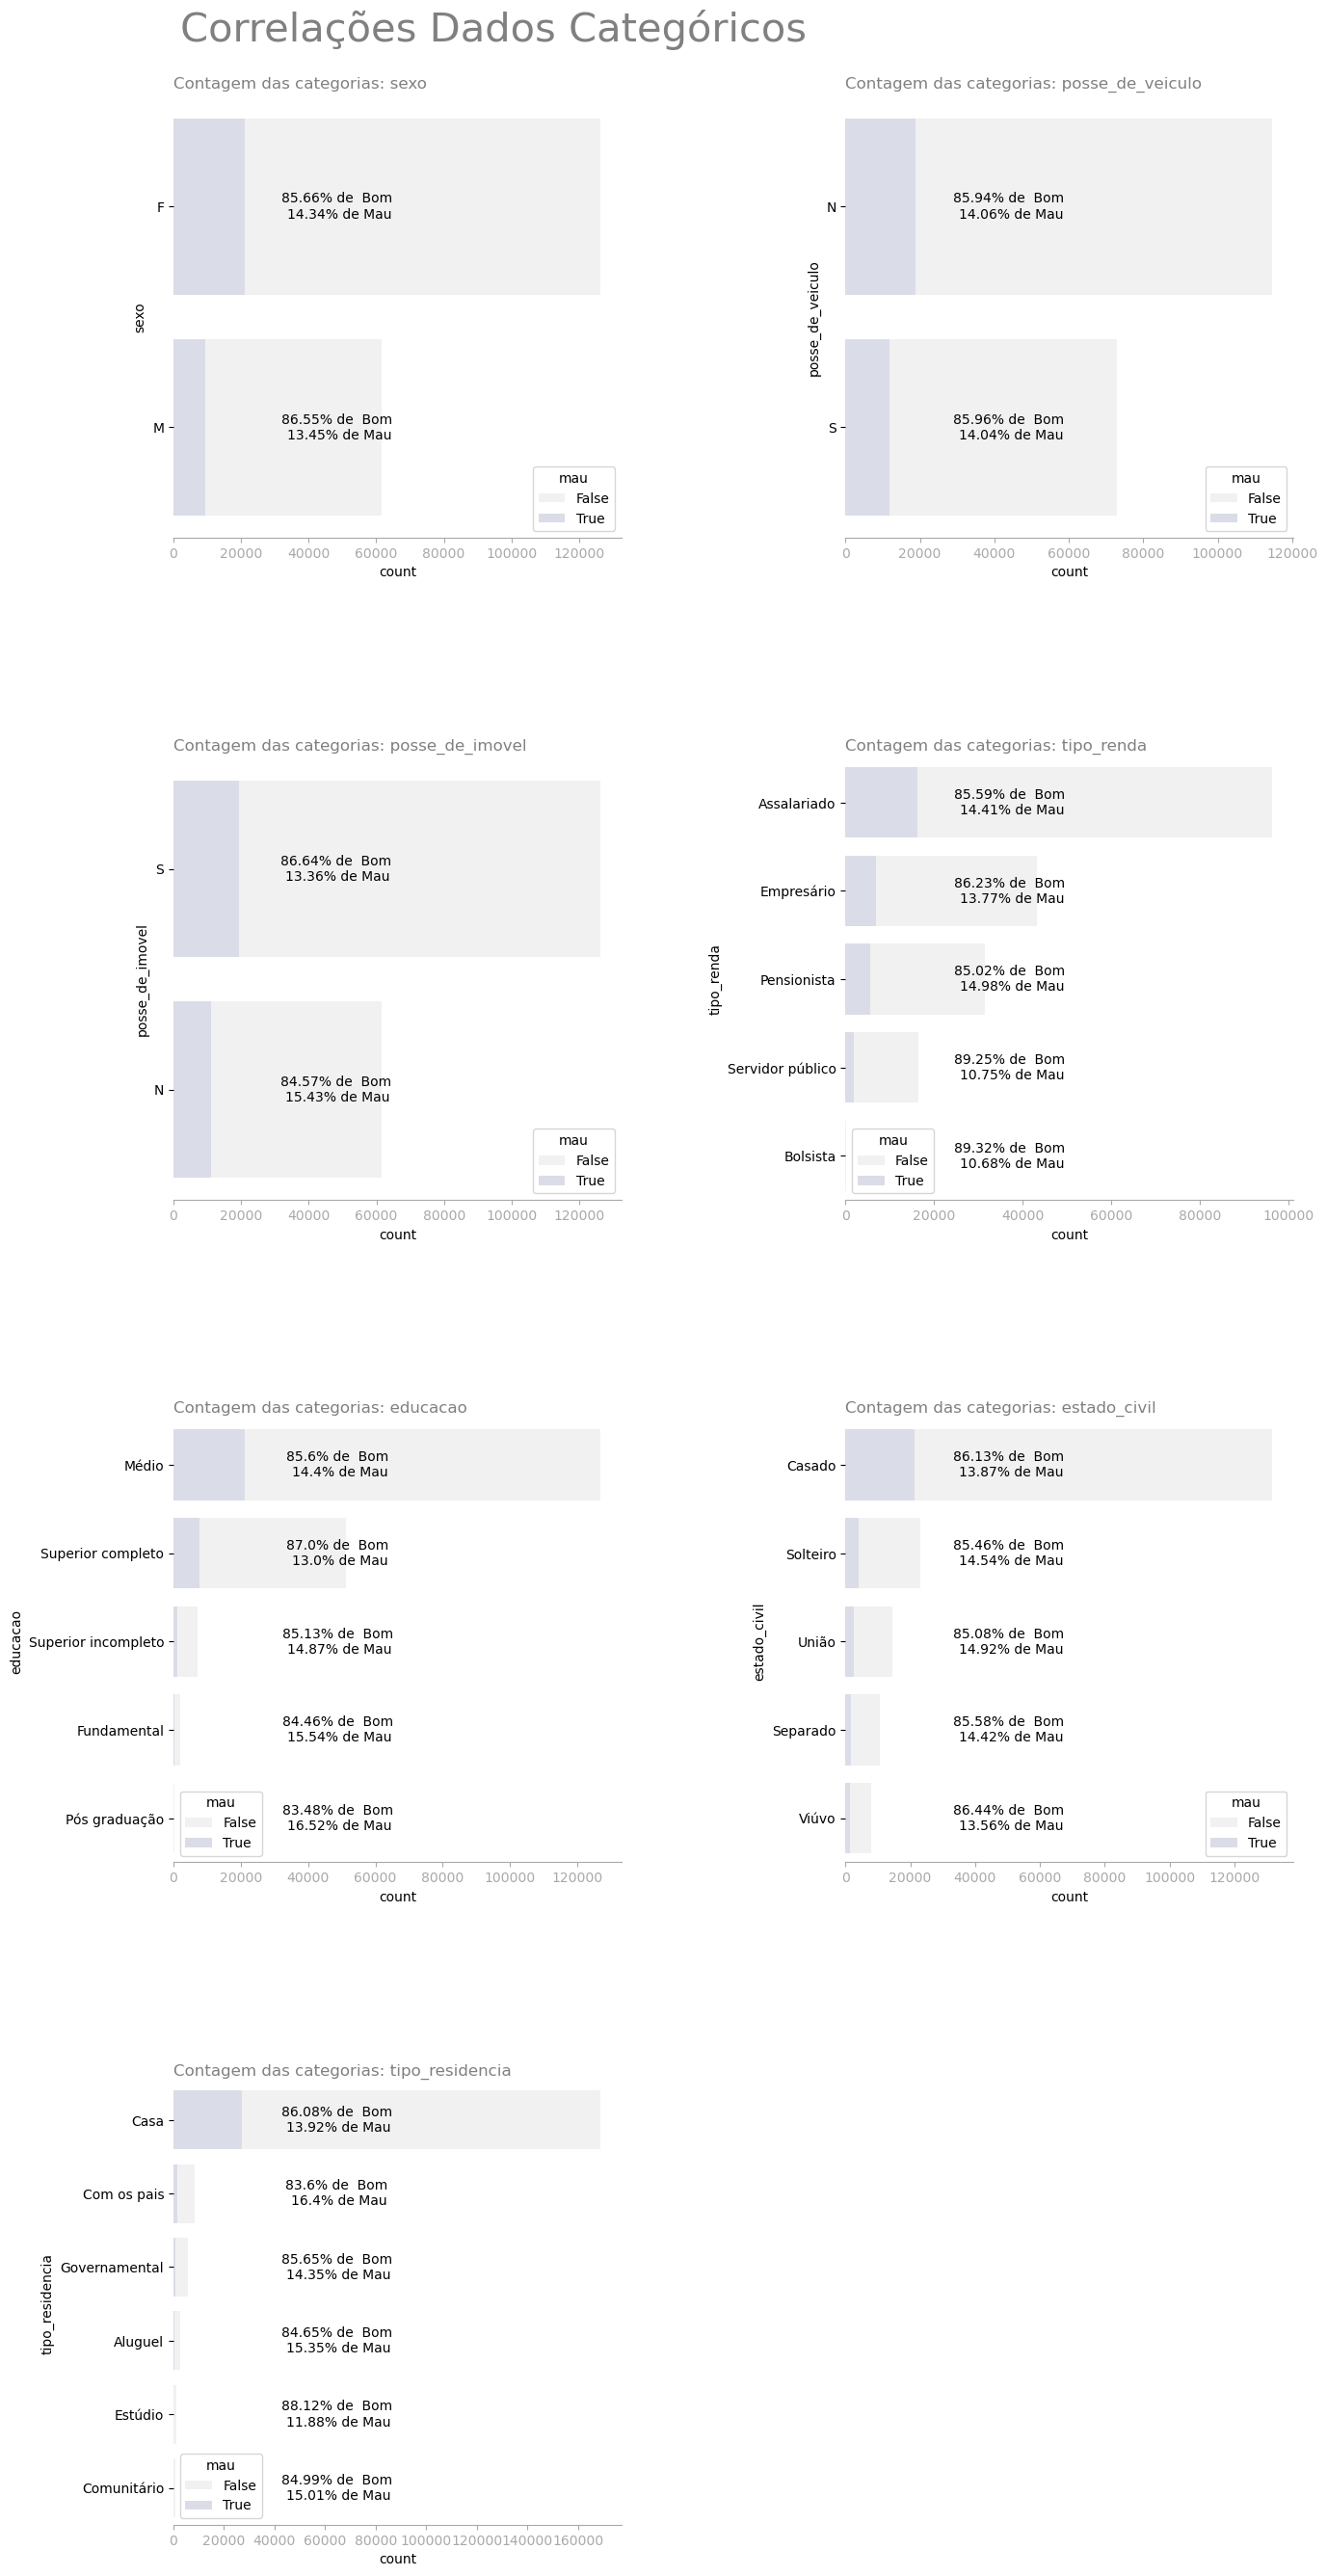

In [22]:
corre_cat(a_c, 'mau', (4,2))

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [23]:
df_1.head()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                N               N           0   Empresário   
1    F                S               S           0  Assalariado   
2    F                N               N           2  Assalariado   
3    F                N               N           0  Assalariado   
4    F                S               N           0  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                Médio     Solteiro            Casa     43       6.873973   
1                Médio       Casado            Casa     35       4.526027   
2                Médio       Casado            Casa     31       0.243836   
3                Médio       Casado            Casa     54      12.772603   
4  Superior incompleto     Solteiro            Casa     31       8.432877   

   qt_pessoas_residencia     renda    mau  mes  
0                    1.0   2515.39  False    1  
1                    2.0   3180.19  False    1  
2                    4.0   1582.29  False    1  
3                    2.0  13721.17  False    1  
4                    1.0   2891.08  False    1

In [71]:
class Balanceamento(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rus = RandomUnderSampler(random_state=42)
        X_ = X.copy()
        y_ = X_.pop('mau')

        X_resampled, y_resampled = rus.fit_resample(X_, y_)
        X_resampled['mau'] = y_resampled

        return X_resampled

class Processamento(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, a):  
        X = a.copy()
        
        X['tempo_emprego'] = np.log(X['tempo_emprego']+1)
        X['renda'] = np.log(X['renda']+1)
        X['renda_cat'] = LabelEncoder().fit_transform(pd.qcut(X['renda'],q=5).astype(str)).astype(str)
        X['tempo_emprego_cat'] = LabelEncoder().fit_transform(pd.qcut(X['tempo_emprego'],q=5).astype(str)).astype(str)
        X['idade_cat'] = LabelEncoder().fit_transform(pd.qcut(X['idade'],q=5).astype(str)).astype(str)
        X.loc[X['qt_pessoas_residencia'] > 5, 'qt_pessoas_residencia'] =  5
        X.loc[X['qtd_filhos'] > 3, 'qtd_filhos'] =  3
        X.loc[X['educacao'] == 'Pós graduação', 'educacao'] = 'Superior completo'
        X.loc[X['tipo_renda'] == 'Bolsista', 'tipo_renda'] = 'Pensionista'
        
        # Criando listas com os atributos numéricos e categóricos
        numeric_features = X.select_dtypes(include=np.number).columns.tolist()
        categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()


        # Sequência para tranformar os dados numéricos
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        # Sequência para transformar os dados categóricos
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy = ('most_frequent'))),
            ('onehot', OneHotEncoder(handle_unknown = 'ignore', drop='first'))
        ])

        # Fazer a transformação
        preprocessor = ColumnTransformer(transformers=[
            ('num',numeric_transformer, numeric_features),
            ('cat',categorical_transformer, categorical_features)
        ])

        X_transformed = preprocessor.fit_transform(X)

        columns = numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
        processed_df = pd.DataFrame(X_transformed, columns=columns)
        
        if processed_df['mau_True'].dtype == 'bool':
            processed_df['mau_True'] = processed_df['mau_True'].map({False:0, True:1})

        return processed_df

def modelo_xgb(dados_entrada):
    """
    
    # Modelo de treinamento Extreme Gradient Boosting.
    
    
    """
    X_treino = dados_entrada.copy()
    y_treino = X_treino.pop('mau_True')
    
    parametros = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'num_boost_round':10,
            'eta': 0.1,
            'max_depth': 30,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42
            }

    num_round = 100

    modelo_final = xgb.XGBClassifier(**parametros, n_estimators=num_round)
    modelo_final.fit(X_treino,y_treino)
    
    return modelo_final    


def resultado(y, prev):

    cm = confusion_matrix(y, prev)
    # KS (Kolmogorov-Smirnov)
    fpr, tpr, thresholds = roc_curve(y, prev)
    ks = max(tpr - fpr)

    # Gini
    auc_score = auc(fpr, tpr)
    gini = 2 * auc_score - 1


    print(f"Gini: {gini}\nKS: {ks}")        
    print(classification_report(y, prev))

    # Heatmap da Matriz de Confusão
    figura = plt.figure(figsize=(10, 4))

    plt.subplot2grid((1,2), (0,0))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Pred Bom', 'Pred Mau'],
                yticklabels=['Actual Bom', 'Actual Mau'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')



    plt.subplot2grid((1,2), (0,1))
        # Curva ROC
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    plt.show()


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [62]:
def modelo_final():
    """
    Essa função me permite ter agilidade na hora de testar diferentes combinações nos dados para alcançar um resultado 
    mais preciso sobre negação de crédito. 
    
    """
    # Pipe Line Ajustes dos dados
    pipe = Pipeline([
    ('balanceamento', Balanceamento()),
    ('pre_processamento', Processamento())
    ])

    df_tratado = pipe.fit_transform(df_1)
    
    # Passando no modelo 
    modelo = modelo_xgb(df_tratado)
    
    # Tratar os dados de treino.
    eval_tratado = Processamento().fit_transform(evalu)
    eval_tratado.head()
    
    # Previsão do modelo

    X_teste = eval_tratado.copy()
    y_teste = X_teste.pop('mau_True')
    y_prev = modelo.predict(X_teste)
    
    # Avaliação dos resultados.

    return resultado(y_teste, y_prev)
    

Gini: 0.21353481988257883
KS: 0.21353481988257894
              precision    recall  f1-score   support

         0.0       0.83      0.52      0.64     45783
         1.0       0.34      0.69      0.45     16202

    accuracy                           0.57     61985
   macro avg       0.58      0.61      0.55     61985
weighted avg       0.70      0.57      0.59     61985



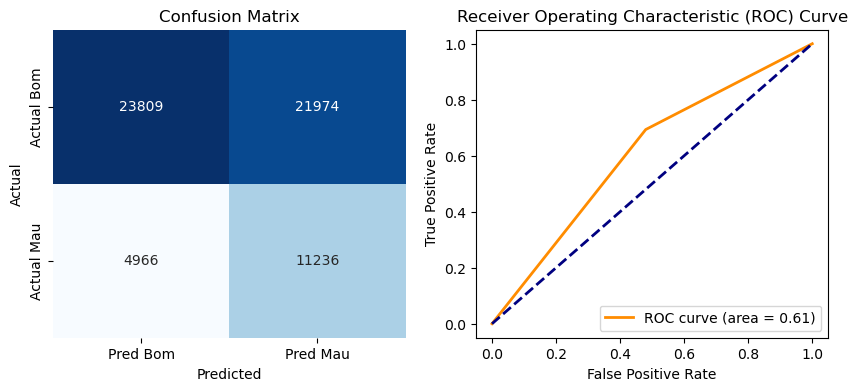

In [72]:
# Modelo base somente com Tratamento simples
modelo_final()